In [23]:
!pip3 install -q --upgrade pip
!pip3 install -q pandas numpy matplotlib seaborn openpyxl climateserv requests netCDF4 xarray pyproj geopandas

In [33]:
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import geopandas as gpd
from typing import List
from pathlib import Path
from scipy.spatial import KDTree
from shapely.geometry import Point
# Calculate the path to the scripts folder relative to the current notebook.
scripts_dir = Path("../../").resolve()

# Add the scripts directory to the sys.path if it's not already there.
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

In [25]:
def analyze_nasadem_file(file_path: str) -> None:
    """
    Analyze a NASADEM NetCDF file and print out its contents, such as variable names,
    dimensions, and min/max values for longitude and latitude.

    Args:
    file_path (str): The path to the NASADEM NetCDF file.
    """
    # Open the NetCDF file
    dataset = nc.Dataset(file_path, 'r')

    # Print general information about the file
    print('##################################################')
    print(f"Analyzing file: {file_path}")
    print("Variables in this file:")
    for var in dataset.variables:
        print(f" - {var}: {dataset.variables[var].dimensions}, {dataset.variables[var].shape}")

    # Check for common variables like longitude and latitude
    if 'lon' in dataset.variables and 'lat' in dataset.variables:
        lon = dataset.variables['lon'][:]
        lat = dataset.variables['lat'][:]
        print(f"Longitude range: {np.min(lon)} to {np.max(lon)}")
        print(f"Latitude range: {np.min(lat)} to {np.max(lat)}")
    
    # Close the dataset
    dataset.close()

# Paths to your files
file_paths = [
    '../../data/original_data/jay_files/Topography_Products/Curvature.nc',
    '../../data/original_data/jay_files/Topography_Products/Drainage_Density.nc',
    '../../data/original_data/jay_files/Topography_Products/Slope.nc',
    '../../data/original_data/jay_files/hydrogeology.nc'
]

# Analyze each file
for path in file_paths:
    analyze_nasadem_file(file_path=path)

##################################################
Analyzing file: ../../data/original_data/jay_files/Topography_Products/Curvature.nc
Variables in this file:
 - lon: ('lon',), (11915,)
 - lat: ('lat',), (2872,)
 - Curvatu_tif2: ('lat', 'lon'), (2872, 11915)
Longitude range: -17.078611111124776 to -13.769166666697293
Latitude range: 13.077222222232688 to 13.874722222230263
##################################################
Analyzing file: ../../data/original_data/jay_files/Topography_Products/Drainage_Density.nc
Variables in this file:
 - lon: ('lon',), (10937,)
 - lat: ('lat',), (2873,)
 - Drainage_density: ('lat', 'lon'), (2873, 10937)
Longitude range: -16.806781756020996 to -13.769003978257615
Latitude range: 13.077083333343863 to 13.874861111119214
##################################################
Analyzing file: ../../data/original_data/jay_files/Topography_Products/Slope.nc
Variables in this file:
 - lon: ('lon',), (11915,)
 - lat: ('lat',), (2872,)
 - Slope_tif2: ('lat', 'lon')

In [26]:
def nc_to_dataframe(file_path: str, var_name: str, dataset_name: str) -> pd.DataFrame:
    """
    Convert a NetCDF file to a pandas DataFrame and print the percentage of NaN values for the specified variable.

    Args:
    file_path (str): Path to the .nc file.
    var_name (str): Name of the variable in the .nc file to convert.
    dataset_name (str): Descriptive name for the dataset.

    Returns:
    pd.DataFrame: DataFrame representation of the NetCDF variable.
    """
    # Open the .nc file
    ds = xr.open_dataset(file_path)

    # Select the variable
    data = ds[var_name]

    # Convert to DataFrame
    df = data.to_dataframe().reset_index()

    # Calculate and print the percentage of NaN values
    nan_percentage = df[var_name].isna().mean() * 100
    print(f"DataFrame from {file_path} - Variable: {var_name}")
    print(df.head())  # Display the first few rows of the DataFrame
    print(f"Percentage of NaN values in '{var_name}': {nan_percentage:.2f}%")
    print('-' * 50)  # Separator

    # Store the DataFrame in a global variable
    globals()[f'df_{dataset_name}'] = df

# File paths, variable names, and dataset names
file_var_pairs = [
    ('../../data/original_data/jay_files/Topography_Products/Curvature.nc', 'Curvatu_tif2', 'curvature'),
    ('../../data/original_data/jay_files/Topography_Products/Drainage_Density.nc', 'Drainage_density', 'drainage_density'),
    ('../../data/original_data/jay_files/Topography_Products/Slope.nc', 'Slope_tif2', 'slope'),
    ('../../data/original_data/jay_files/hydrogeology.nc', 'Hydrogeo', 'Hydrogeology')
]

# Process each file
for file_path, var_name, dataset_name in file_var_pairs:
    nc_to_dataframe(file_path=file_path, var_name=var_name, dataset_name=dataset_name)

# After running this script, you can access each DataFrame directly, e.g., df_ndvi, df_ndwi, etc.

DataFrame from ../../data/original_data/jay_files/Topography_Products/Curvature.nc - Variable: Curvatu_tif2
         lat        lon  Curvatu_tif2
0  13.874722 -17.078611           NaN
1  13.874722 -17.078333           NaN
2  13.874722 -17.078056           NaN
3  13.874722 -17.077778           NaN
4  13.874722 -17.077500           NaN
Percentage of NaN values in 'Curvatu_tif2': 2.38%
--------------------------------------------------
DataFrame from ../../data/original_data/jay_files/Topography_Products/Drainage_Density.nc - Variable: Drainage_density
         lat        lon  Drainage_density
0  13.874861 -16.806782               0.0
1  13.874861 -16.806504               0.0
2  13.874861 -16.806226               0.0
3  13.874861 -16.805948               0.0
4  13.874861 -16.805671               0.0
Percentage of NaN values in 'Drainage_density': 0.00%
--------------------------------------------------
DataFrame from ../../data/original_data/jay_files/Topography_Products/Slope.nc - Variab

In [27]:
df = pd.read_csv("../../data/final_dataset/original/gambia_lat_and_long.csv")
df

,long,lat
0,-16.670616,13.488346
1,-16.665998,13.488376
2,-16.684438,13.483734
3,-16.679820,13.483765
4,-16.675202,13.483796
...,...,...
2869,-16.746177,13.076569
2870,-16.741567,13.076600
2871,-16.736957,13.076631
2872,-16.732347,13.076662


In [28]:
df_drainage_density

,lat,lon,Drainage_density
0,13.874861,-16.806782,0.000000
1,13.874861,-16.806504,0.000000
2,13.874861,-16.806226,0.000000
3,13.874861,-16.805948,0.000000
4,13.874861,-16.805671,0.000000
...,...,...,...
31421996,13.077083,-13.770115,10.032833
31421997,13.077083,-13.769837,10.017525
31421998,13.077083,-13.769560,9.998237
31421999,13.077083,-13.769282,9.974904


In [29]:
df_curvature

,lat,lon,Curvatu_tif2
0,13.874722,-17.078611,NaN
1,13.874722,-17.078333,NaN
2,13.874722,-17.078056,NaN
3,13.874722,-17.077778,NaN
4,13.874722,-17.077500,NaN
...,...,...,...
34219875,13.077222,-13.770278,3.888000e+09
34219876,13.077222,-13.770000,-1.296000e+09
34219877,13.077222,-13.769722,1.296000e+09
34219878,13.077222,-13.769444,-2.592000e+09


In [32]:
df_Hydrogeology

,lat,lon,Hydrogeo
0,21.611112,-17.52524,NaN
1,21.611112,-17.50524,NaN
2,21.611112,-17.48524,NaN
3,21.611112,-17.46524,NaN
4,21.611112,-17.44524,NaN
...,...,...,...
132140,10.931112,-12.68524,NaN
132141,10.931112,-12.66524,NaN
132142,10.931112,-12.64524,NaN
132143,10.931112,-12.62524,NaN


In [31]:
df_slope

,lat,lon,Slope_tif2
0,13.874722,-17.078611,NaN
1,13.874722,-17.078333,NaN
2,13.874722,-17.078056,NaN
3,13.874722,-17.077778,NaN
4,13.874722,-17.077500,NaN
...,...,...,...
34219875,13.077222,-13.770278,NaN
34219876,13.077222,-13.770000,NaN
34219877,13.077222,-13.769722,NaN
34219878,13.077222,-13.769444,NaN


In [34]:
def find_nearest_neighbors(df_wells: pd.DataFrame, dfs: List[pd.DataFrame], columns: List[str]) -> pd.DataFrame:
    """
    Finds the nearest neighbor for each dataframe in 'dfs' with respect to the points in df_wells
    and merges the data, including the specified columns in 'columns'.
    """
    # Verify columns in df_wells
    assert 'lat' in df_wells and 'long' in df_wells, "'lat' and 'long' columns must be in df_wells"

    # DataFrame to store results
    result_df = df_wells.copy()

    # Process each dataframe in the list
    for df, column in zip(dfs, columns):
        print(f"Processing dataframe for column '{column}'")

        # Verify columns in each dataframe
        assert 'lat' in df and 'lon' in df, f"'lat' and 'lon' columns must be in {df}"

        # Build KDTree
        tree = KDTree(df[['lat', 'lon']])

        # List to store combined columns
        combined_data = []

        # Iterate over each row in df_wells
        for index, well in df_wells.iterrows():
            print(f"Analyzing well {index + 1}/{len(df_wells)} for column '{column}'")

            # Find the nearest neighbor
            _, nearest_idx = tree.query([well['lat'], well['long']], k=1)
            nearest_value = df.iloc[nearest_idx][column]
            print(f"Nearest neighbor found for column '{column}': {nearest_value}")

            # Add the found value to the list
            combined_data.append(nearest_value)

        # Add the column to the resulting dataframe
        result_df[column] = combined_data
        print(f"Combination completed for column '{column}'\n")

    return result_df


def save_data(merged_df: pd.DataFrame, save_path: str) -> None:
    """Save the merged data to a CSV file."""
    merged_df.to_csv(save_path, index=False)


In [37]:
dataframes = [df_drainage_density, df_slope, df_Hydrogeology, df_curvature]
columns = ['Drainage_density', 'Slope_tif2', 'Hydrogeo', 'Curvatu_tif2']

merged_df = find_nearest_neighbors(df_wells=df, dfs=dataframes, columns=columns)
#save_data(merged_df=merged_df, save_path='../../data/final_dataset/processed_data/jay_merged_data.csv')

Processing dataframe for column 'Drainage_density'
Analyzing well 1/2874 for column 'Drainage_density'
Nearest neighbor found for column 'Drainage_density': 13.499495506286621
Analyzing well 2/2874 for column 'Drainage_density'
Nearest neighbor found for column 'Drainage_density': 14.573663711547852
Analyzing well 3/2874 for column 'Drainage_density'
Nearest neighbor found for column 'Drainage_density': 15.60971450805664
Analyzing well 4/2874 for column 'Drainage_density'
Nearest neighbor found for column 'Drainage_density': 13.571120262145996
Analyzing well 5/2874 for column 'Drainage_density'
Nearest neighbor found for column 'Drainage_density': 13.922872543334961
Analyzing well 6/2874 for column 'Drainage_density'
Nearest neighbor found for column 'Drainage_density': 16.095518112182617
Analyzing well 7/2874 for column 'Drainage_density'
Nearest neighbor found for column 'Drainage_density': 18.692808151245117
Analyzing well 8/2874 for column 'Drainage_density'
Nearest neighbor found 

,long,lat,Drainage_density,Slope_tif2,Hydrogeo,Curvatu_tif2
0,-16.670616,13.488346,13.499496,0.0,5.0,-0.000000e+00
1,-16.665998,13.488376,14.573664,0.0,5.0,-0.000000e+00
2,-16.684438,13.483734,15.609715,0.0,5.0,-0.000000e+00
3,-16.679820,13.483765,13.571120,0.0,5.0,-0.000000e+00
4,-16.675202,13.483796,13.922873,0.0,5.0,-0.000000e+00
...,...,...,...,...,...,...
2869,-16.746177,13.076569,34.977886,NaN,NaN,2.592000e+09
2870,-16.741567,13.076600,44.632805,NaN,NaN,-5.184000e+09
2871,-16.736957,13.076631,49.922588,NaN,NaN,3.888000e+09
2872,-16.732347,13.076662,49.457001,NaN,5.0,-3.888000e+09


In [38]:
merged_df

,long,lat,Drainage_density,Slope_tif2,Hydrogeo,Curvatu_tif2
0,-16.670616,13.488346,13.499496,0.0,5.0,-0.000000e+00
1,-16.665998,13.488376,14.573664,0.0,5.0,-0.000000e+00
2,-16.684438,13.483734,15.609715,0.0,5.0,-0.000000e+00
3,-16.679820,13.483765,13.571120,0.0,5.0,-0.000000e+00
4,-16.675202,13.483796,13.922873,0.0,5.0,-0.000000e+00
...,...,...,...,...,...,...
2869,-16.746177,13.076569,34.977886,NaN,NaN,2.592000e+09
2870,-16.741567,13.076600,44.632805,NaN,NaN,-5.184000e+09
2871,-16.736957,13.076631,49.922588,NaN,NaN,3.888000e+09
2872,-16.732347,13.076662,49.457001,NaN,5.0,-3.888000e+09


In [39]:
nan_counts = merged_df.isna().sum()
print("NaN Counts in each column:\n", nan_counts)


NaN Counts in each column:
 long                   0
lat                    0
Drainage_density       0
Slope_tif2            10
Hydrogeo            1091
Curvatu_tif2           0
dtype: int64


In [40]:
from scipy.spatial import cKDTree

def populate_nan_with_nearest(df_wells: pd.DataFrame, original_dfs: List[pd.DataFrame], columns: List[str]) -> pd.DataFrame:
    """
    Populates NaN values in df_wells using the nearest non-NaN value from the corresponding original dataframes.
    """
    # Iterate over the columns and corresponding original dataframes
    for column, original_df in zip(columns, original_dfs):
        # Build a KDTree with non-NaN values
        valid_rows = original_df.dropna(subset=[column])
        tree = cKDTree(valid_rows[['lat', 'lon']])

        # Iterate over rows with NaN in the current column
        nan_rows = df_wells[df_wells[column].isna()]
        for idx, row in nan_rows.iterrows():
            if len(valid_rows) == 0:
                print(f"No valid data to replace NaNs for column '{column}'")
                break

            # Find the nearest non-NaN neighbor
            _, nearest_idx = tree.query([row['lat'], row['long']], k=1)
            nearest_valid_value = valid_rows.iloc[nearest_idx][column]

            # Replace NaN with the nearest valid value
            df_wells.at[idx, column] = nearest_valid_value
            print(f"Replaced NaN in row {idx}, column '{column}' with value: {nearest_valid_value}")

    return df_wells


In [42]:
# Assuming original dataframes are named df_slope, df_Hydrology, df_curvature, df_drainage_density
original_dfs = [df_drainage_density, df_slope, df_Hydrogeology, df_curvature]
columns = ['Drainage_density', 'Slope_tif2', 'Hydrogeo', 'Curvatu_tif2']

# Populate NaNs in merged_df
merged_df = populate_nan_with_nearest(df_wells=merged_df, original_dfs=original_dfs, columns=columns)

Replaced NaN in row 2864, column 'Slope_tif2' with value: 0.0
Replaced NaN in row 2865, column 'Slope_tif2' with value: 0.9290392994880676
Replaced NaN in row 2866, column 'Slope_tif2' with value: 2.563905715942383
Replaced NaN in row 2867, column 'Slope_tif2' with value: 1.9147183895111084
Replaced NaN in row 2868, column 'Slope_tif2' with value: 0.9853842258453369
Replaced NaN in row 2869, column 'Slope_tif2' with value: 1.642019271850586
Replaced NaN in row 2870, column 'Slope_tif2' with value: 2.32153058052063
Replaced NaN in row 2871, column 'Slope_tif2' with value: 2.7068135738372803
Replaced NaN in row 2872, column 'Slope_tif2' with value: 0.7344942092895508
Replaced NaN in row 2873, column 'Slope_tif2' with value: 0.9290392994880676
Replaced NaN in row 110, column 'Hydrogeo' with value: 5.0
Replaced NaN in row 143, column 'Hydrogeo' with value: 5.0
Replaced NaN in row 144, column 'Hydrogeo' with value: 5.0
Replaced NaN in row 177, column 'Hydrogeo' with value: 5.0
Replaced NaN 

In [43]:
merged_df

,long,lat,Drainage_density,Slope_tif2,Hydrogeo,Curvatu_tif2
0,-16.670616,13.488346,13.499496,0.000000,5.0,-0.000000e+00
1,-16.665998,13.488376,14.573664,0.000000,5.0,-0.000000e+00
2,-16.684438,13.483734,15.609715,0.000000,5.0,-0.000000e+00
3,-16.679820,13.483765,13.571120,0.000000,5.0,-0.000000e+00
4,-16.675202,13.483796,13.922873,0.000000,5.0,-0.000000e+00
...,...,...,...,...,...,...
2869,-16.746177,13.076569,34.977886,1.642019,5.0,2.592000e+09
2870,-16.741567,13.076600,44.632805,2.321531,5.0,-5.184000e+09
2871,-16.736957,13.076631,49.922588,2.706814,5.0,3.888000e+09
2872,-16.732347,13.076662,49.457001,0.734494,5.0,-3.888000e+09


In [44]:
nan_counts = merged_df.isna().sum()
print("NaN Counts in each column:\n", nan_counts)

NaN Counts in each column:
 long                0
lat                 0
Drainage_density    0
Slope_tif2          0
Hydrogeo            0
Curvatu_tif2        0
dtype: int64


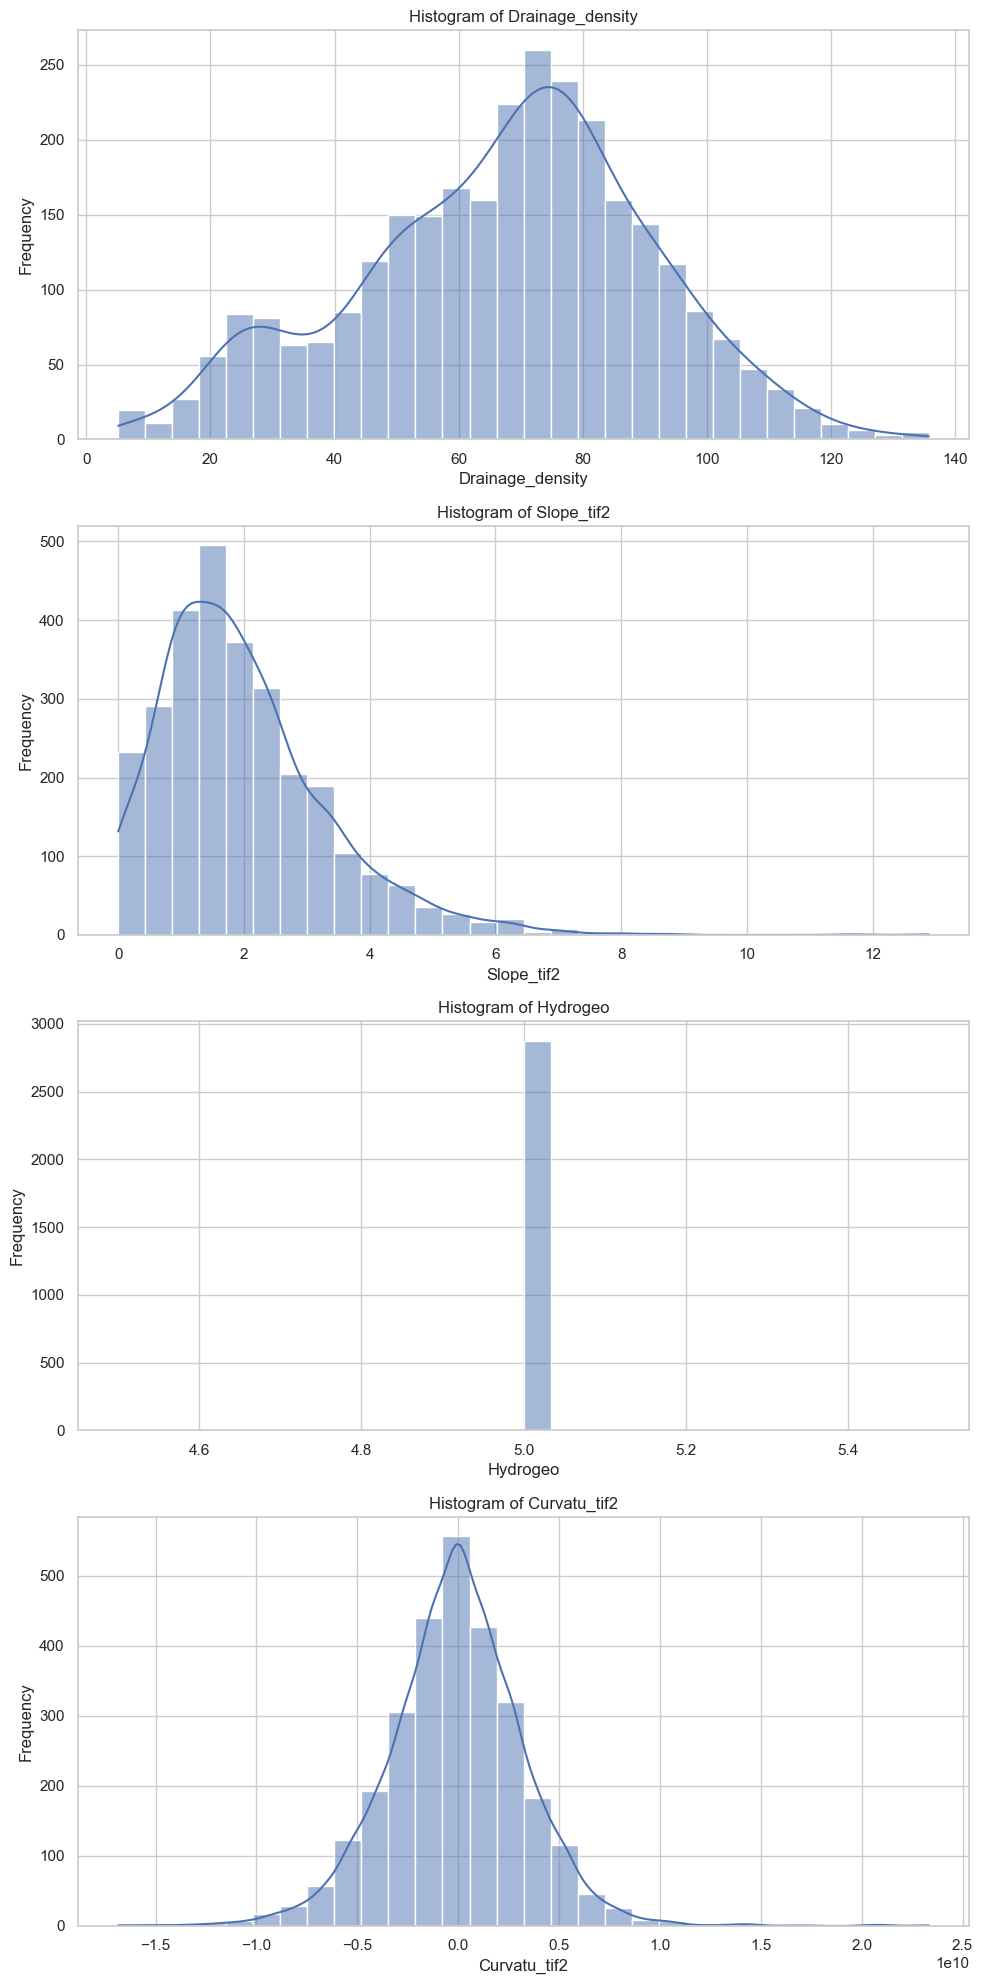

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn plots
sns.set(style="whitegrid")

# List of columns to plot
columns_to_plot = ['Drainage_density', 'Slope_tif2', 'Hydrogeo', 'Curvatu_tif2']

# Creating a figure and a set of subplots
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 5 * len(columns_to_plot)))

for i, col in enumerate(columns_to_plot):
    sns.histplot(merged_df[col], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()
plt.show()


In [46]:
save_data(merged_df=merged_df, save_path='../../data/final_dataset/processed_data/jay_merged_data.csv')